# <br> <center> Coalition, Inc: Honeypot Data Investigation and Modeling Results <br> </center>

<br> <center> Drew Zinder <br>
    DrewZinder@gmail.com <br>
    April 21, 2023 </center>

### Objective
Given a sample of of Coalition's honeypot data, create a descriptive model of what factors contribute to DDoS attacks. 
    
### General Methodology
* Data is investigated, cleaned, and has factors which could introduce modeling bias removed
* Categorical or nominal values are encoded via dummy variables
* In the interest of interpertability, a probit regression model is employed initially.  
    * Unfortunately, the dataset is quasi-separated (repeated instances of perfect predictions), and maximum likelihood estimates do not converge.  
* An XGBoost model is utilized subsequently, with model performance evaluated via ROC-AUC, and confusion matricies.
    * As the final model predicts DDoS attacks perfectly, hyperparameter tuning for the XGBoost model is excluded from the analysis.

### Conclusions
* The `payload` variable seems to be completely indicitative of whether or not an event was classified as a DDoS attack
    * This is not unexpected; as 50,000 events were recorded in just over an hour, we would expect the the classification to follow a rules-based system.  
    * XGBoost model performs perfectly (AUC score of 1) when the `has_payload` variable is included 
    * The same model performs very poorly (AUC score of 0.557) when the `has_payload` variable is excluded

### Next Steps
* It would be interesting to investigate what factors could _lead_ to an eventual DDoS attack, to allow for better preventative measures.  
* Data is "censored"--we only record an event when either a person or an automated process interacts with the website.  
    * It could be interesting to set up a comprable "non-honeypot" website to act as a control for A/B testing. 
* Would be very useful to have non-proxy IP addresses, to associate series of events for grouped analysis
    * (This data almost certainly does not exist)
<br>

## Import Libraries, Set Options, & Load Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import statsmodels.api 
import statsmodels as sm
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# Supress Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Set options to display full dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

In [3]:
# Read in data
data = pd.read_json(r'C:\Users\drewz\Documents\Python Scripts\Coalition\honeypot.json')

### Create a dictionary of the count threshold for creating dummy variables
Many data fields contain nominal data, and must be converted into a series of dummy or one-hot variables to be analyzed mathematically.  We don't want to create a variable for each one, however, as that would be significantly more computationally expensive, and similarly reduce the statistical power.  This dictionary creates the cutoff thresholds for counts of occurances for each of the included variables.

In [4]:
min_value_counts = {'port': 100, 
                    'ip': 1000,
                    'connecting_country': 500,
                    'host_country': 100
                   } 

### Data Investigation:

* `timestamp:` all data between 21:59 and 23:00 on 4/12.  
  * Should generally be safe to treat this as cross-sectional data, but should still do a time-based test/train split, to be safe.  
* `tags:` variety of entries, presumably some sort of rule-based generation.  
* `payload:` either 'None' or a longer string, usually a browser cookie, presumably.  
* `port:` this field may contain useful information.  Encode as dummy variables for counts above a certain limit.  
* `country_name:` country the connection is coming from.  Same as above.  Dummy variables for counts above a limit.  
* `as_num:` only eight values.  Convert all to dummy.  
* `proxy_type:` either DCH or VPN, both of which are a proxy (as the name would suggest).  Can be encoded in a single dummy variable. 
* `ip:` Likely the IP address of whatever proxy server is being used (so not as informative as it would be otherwise).  Create dummy variables for counts above a certain limit.  
* `country_name_1:` country the connection is going to.  Create dummies for counts above a certain limit.  


### Key Observations:
  * Trying to predict occurances of DDoS attacks (instances where the "tags" field contains "TCP_SYN").  
    * As there were 50,000 records generated in just over an hour, this is likely auto-generated, based on a set of rules. <br> <br>
  * All data appears to have some type of proxy (VPN, DCH).  One IP address likely represents multiple individuals / computers.
    * Individual IP addresses also have multiple connecting_country entries. <br> <br>
  * We shouldn't aggregate up based on IP address--all data points should be treated as separate events.  <br> <br>
  * All data is nominal--can contain useful information, but will all need to be one-hot encoded (either explicitly or implicitly)

## Data Cleaning & Initial One-Hot Encoding

In [5]:
# Remove character artifacts in 'tags' column
data.tags = data.tags.astype(str)
data.tags = data.tags.str.replace('[', '') .str.replace(']', '').str.replace('\'', '')

In [6]:
# Rename columns
data = data.rename(columns = {'country_name' : 'connecting_country', 
                              'country_name_1': 'host_country'})

In [7]:
# Create TCP_SYN flag, accounting for "TOR, TCP_SYN" tag
data['is_tcp_syn'] = np.where(data.tags.str.contains('TCP_SYN'), 1, 0) 

# Create has_payload flag
data['has_payload'] = np.where(data.payload.notnull(), 1, 0)

# Create is_vpn flag
data['is_vpn'] = np.where(data.proxy_type == 'VPN', 1, 0)

## Data Exploration

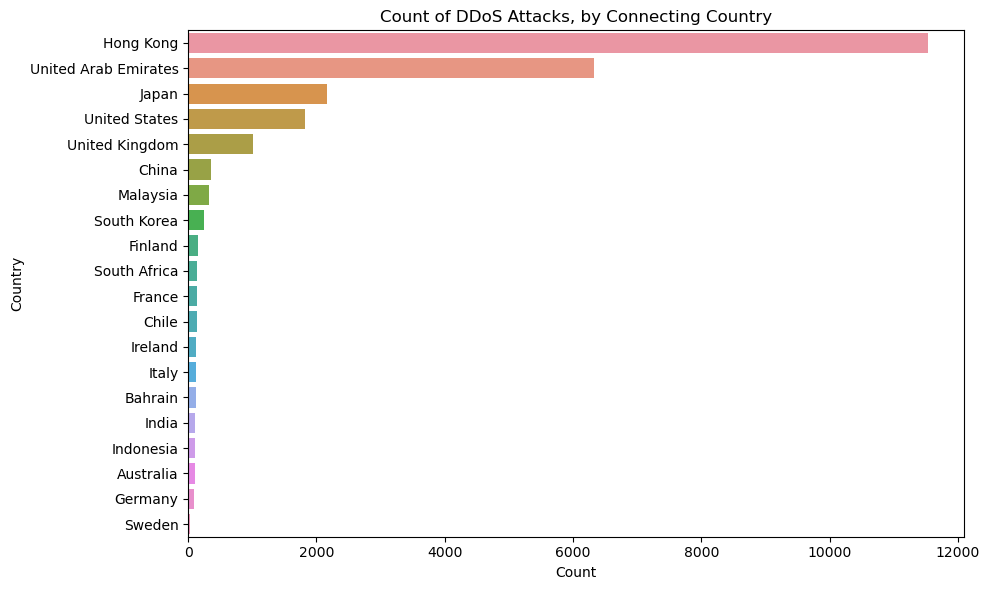

In [8]:
connecting_country_counts = pd.DataFrame(data[data.tags.str.contains('TCP_SYN')]['connecting_country'].value_counts()).reset_index().rename(columns = {'index': 'Country', 
                                                                                                                                                       'connecting_country': 'Count'})

plt.figure(figsize=(10,6))
sns.set_palette('pastel')
sns.barplot(x='Count',
            y='Country',
            data=connecting_country_counts) 
plt.title('Count of DDoS Attacks, by Connecting Country')
plt.tight_layout()
plt.show()

In [9]:
data.head()

,timestamp,tags,payload,port,connecting_country,as_num,proxy_type,ip,host_country,is_tcp_syn,has_payload,is_vpn
0,2023-04-12 22:28:12.843000+00:00,ICMP_ECHO_REQUEST,None,0,United Arab Emirates,8075,DCH,3.8.237.65,United Kingdom,0,0,0
1,2023-04-12 22:31:09.462000+00:00,ICMP_ECHO_REQUEST,None,0,United Arab Emirates,8075,DCH,13.42.34.10,United Kingdom,0,0,0
2,2023-04-12 22:15:07.789000+00:00,ICMP_ECHO_REQUEST,None,0,United Arab Emirates,8075,DCH,71.136.70.3,China,0,0,0
3,2023-04-12 22:40:06.014000+00:00,ICMP_ECHO_REQUEST,None,0,United Arab Emirates,8075,DCH,16.50.56.182,Australia,0,0,0
4,2023-04-12 22:35:06.097000+00:00,ICMP_ECHO_REQUEST,None,0,United Arab Emirates,8075,DCH,16.50.61.107,Australia,0,0,0


In [17]:
data[data.as_num == 8075].head()

,timestamp,tags,payload,port,connecting_country,as_num,proxy_type,ip,host_country,is_tcp_syn,has_payload,is_vpn
0,2023-04-12 22:28:12.843000+00:00,ICMP_ECHO_REQUEST,None,0,United Arab Emirates,8075,DCH,3.8.237.65,United Kingdom,0,0,0
1,2023-04-12 22:31:09.462000+00:00,ICMP_ECHO_REQUEST,None,0,United Arab Emirates,8075,DCH,13.42.34.10,United Kingdom,0,0,0
2,2023-04-12 22:15:07.789000+00:00,ICMP_ECHO_REQUEST,None,0,United Arab Emirates,8075,DCH,71.136.70.3,China,0,0,0
3,2023-04-12 22:40:06.014000+00:00,ICMP_ECHO_REQUEST,None,0,United Arab Emirates,8075,DCH,16.50.56.182,Australia,0,0,0
4,2023-04-12 22:35:06.097000+00:00,ICMP_ECHO_REQUEST,None,0,United Arab Emirates,8075,DCH,16.50.61.107,Australia,0,0,0


In [15]:
data.as_num.value_counts()

45102     40406
14061     2344 
396982    2222 
16509     2053 
8075      2000 
63949     405  
37963     360  
14618     210  
Name: as_num, dtype: int64

In [10]:
data.host_country.value_counts()

China                   39683
Netherlands             6301 
Spain                   1250 
Vietnam                 896  
United States           531  
Russia                  332  
Germany                 141  
Bulgaria                116  
Monaco                  99   
United Kingdom          97   
Panama                  83   
Romania                 80   
Hong Kong               56   
Singapore               51   
India                   26   
Japan                   25   
South Korea             21   
Indonesia               20   
Colombia                19   
Thailand                16   
Australia               16   
Canada                  15   
Switzerland             13   
Lithuania               12   
Ireland                 12   
Brazil                  12   
France                  10   
Bahrain                 9    
Malaysia                7    
Taiwan                  6    
Italy                   5    
South Africa            4    
Nepal                   3    
United Ara

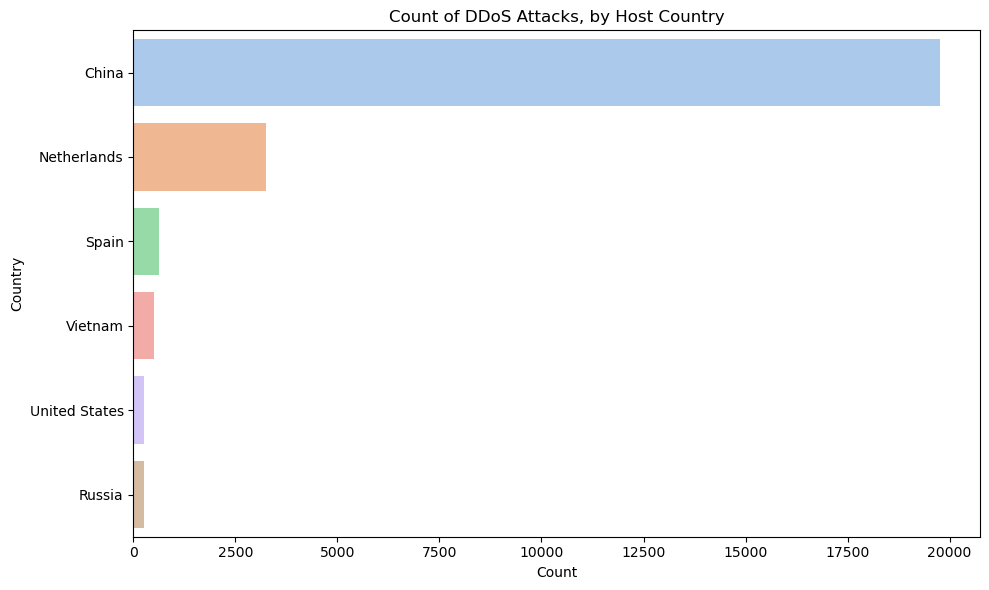

In [9]:
# Sharp dropoff after top 6 countries--only include those in the graph
host_country_counts = pd.DataFrame(data[data.tags.str.contains('TCP_SYN')]['host_country'].value_counts()[:6]).reset_index().rename(columns = {'index': 'Country', 
                                                                                                                                               'host_country': 'Count'})

plt.figure(figsize=(10,6))
sns.set_palette('pastel')
sns.barplot(x='Count',
            y='Country',
            data=host_country_counts) 
plt.title('Count of DDoS Attacks, by Host Country')
plt.tight_layout()
plt.show()

## One-Hot Encoding

The `pd.get_dummies` function is incredibly useful, but it doesn't contain an option to only create dummy variables out of <i> some </i> values.  Fortunately, however, we can replace values we don't want to encode with NaN, and `get_dummies` will ignore those entries.  

The following section iterates through the items in the `min_value_counts` dictionary, and replaces values that are below the aggregate count cutoff with NaN.  

In [10]:
def values_above_cutoff(df, col, min_val_dict = min_value_counts):

  ''' Generates a list of values in the chosen column, where the counts are above the previously-defined cutoff value. '''

  val_count_dict = df[col].value_counts()
  cleaned_list = [x for x in df[col].unique() if val_count_dict[x] >= min_val_dict[col]]

  return cleaned_list

In [11]:
def selective_dummies(df, min_val_dict = min_value_counts):

  ''' Replace values below the required occurance level with NaN, and generate dummy variable columns from the remainder, allowing us to selectively generate dummy variables'''
  
  for val in min_val_dict:

    count_list = values_above_cutoff(df, val)
   
    df[val] = np.where(df[val].isin(count_list), df[val], np.nan)

  return pd.get_dummies(df, columns = [x for x in min_val_dict])

The `selective_dummies` function is destructive (in that information is eleminated and cannot be recovered), so we make a copy of the dataset, rather than overwriting it. 

The `as_num` field only contains eight distinct values, so all of those can be encoded directly.  To avoid issues with multicollinearity and for consistency with the other encoded variables, the category 'as_num_14618' is dropped. 

In [12]:
data_one_hot = selective_dummies(data)

# as_num only has eight values.  Encode directly. 
data_one_hot = pd.get_dummies(data_one_hot, columns = ['as_num']).drop('as_num_14618', axis = 1) # Drop the smallest category, for multicollenarity (and consistency)

## Data Modeling

#### Create test / train split
While the data has a time component, it's almost certainly not time-dependent.  Still, best to create a test / train split based on timestamp, to be safe.  

In [13]:
# List of rows that do not conatin regression-relevant information:
x_drop = ['timestamp', 'tags', 'payload', 'proxy_type', 'is_tcp_syn'] 

# Sort data my timestamp, then split at 50,000 * 0.75 level (37,500)
train_y = data_one_hot.sort_values('timestamp').iloc[:37500, ]['is_tcp_syn']
train_x = data_one_hot.sort_values('timestamp').iloc[:37500, ].drop(x_drop, axis = 1)

test_y = data_one_hot.sort_values('timestamp').iloc[37500:, ]['is_tcp_syn']
test_x = data_one_hot.sort_values('timestamp').iloc[37500:, ].drop(x_drop, axis = 1)

### Probit Model

In [14]:
probit = sm.discrete.discrete_model.Probit(train_y, train_x)
results = probit.fit(maxiter = 1000) 

results.summary() 

         Current function value: 1.405222
         Iterations: 1000


c:\Users\drewz\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:             is_tcp_syn   No. Observations:                37500
Model:                         Probit   Df Residuals:                    37457
Method:                           MLE   Df Model:                           42
Date:                Fri, 21 Apr 2023   Pseudo R-squ.:                  -1.027
Time:                        17:48:40   Log-Likelihood:                -52696.
converged:                      False   LL-Null:                       -25992.
Covariance Type:            nonrobust   LLR p-value:                     1.000
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
has_payload                               -38.2820   1.33e+04     -0.003      0.998   -2.61e+04     2.6e+04
is_vpn                                    -16.0154   8.92e+21   -1.8e-21      1.000   -1.75e+22    1.75e+22
port_0.0                                  -74.1815        nan        nan        nan         nan         nan
port_1.0                                   -4.2062   8.32e+36  -5.06e-37      1.000   -1.63e+37    1.63e+37
port_5000.0                                20.8322   6455.433      0.003      0.997   -1.26e+04    1.27e+04
port_6000.0                                22.1155   3.59e+05   6.17e-05      1.000   -7.03e+05    7.03e+05
port_7000.0                                -1.0167   4.89e+05  -2.08e-06      1.000   -9.59e+05    9.59e+05
port_9833.0                                 0.4795   3.09e+06   1.55e-07      1.000   -6.05e+06    6.05e+06
ip_103.66.94.148                            1.5700   1.77e+06   8.85e-07      1.000   -3.48e+06    3.48e+06
ip_210.12.140.221                           0.9505   4.45e+05   2.14e-06      1.000   -8.72e+05    8.72e+05
ip_218.59.172.213                           2.1263   1.11e+08   1.91e-08      1.000   -2.18e+08    2.18e+08
ip_219.159.147.162                          1.4646   4.17e+06   3.51e-07      1.000   -8.17e+06    8.17e+06
ip_221.231.126.170                          0.9910   7.49e+05   1.32e-06      1.000   -1.47e+06    1.47e+06
ip_221.231.126.42                           0.8034   3.21e+05    2.5e-06      1.000   -6.29e+05    6.29e+05
ip_222.136.64.66                            1.8689   2.64e+07   7.09e-08      1.000   -5.17e+07    5.17e+07
ip_40.72.188.195                            8.4627      1e+25   8.43e-25      1.000   -1.97e+25    1.97e+25
ip_43.249.193.6                            22.6160        nan        nan        nan         nan         nan
ip_60.171.93.25                            42.3449        nan        nan        nan         nan         nan
ip_85.117.248.26                          -59.1272        nan        nan        nan         nan         nan
ip_89.248.165.167                         -21.0607   1.21e+04     -0.002      0.999   -2.37e+04    2.36e+04
ip_89.248.174.227                           0.7862    4.9e+05   1.61e-06      1.000    -9.6e+05     9.6e+05
connecting_country_Hong Kong                0.9143   6484.147      0.000      1.000   -1.27e+04    1.27e+04
connecting_country_Japan                  -20.1500    610.259     -0.033      0.974   -1216.236    1175.935
connecting_country_Malaysia                44.7686   1.46e+04      0.003      0.998   -2.85e+04    2.86e+04
connecting_country_South Korea             -0.6815   3.77e+08  -1.81e-09      1.000    -7.4e+08     7.4e+08
connecting_country_United Arab Emirates     0.8940   6484.147      0.000      1.000   -1.27e+04    1.27e+04
connecting_country_United Kingdom           4.4469        nan        nan        nan         nan         nan
c

Model did not converge, due to quasi-separated nature of the data (ie, all of our relevant variables are one-hot encoded, and the relevant event can be predicted perfectly).  

Attempted to create a model just looking at both the `connecting_country` and `host_country` variables, to see if that would remove enough perfect predictions.

In [15]:
# Countries-only model
varlist = [col for col in data_one_hot.columns if 'country' in col]

probit = sm.discrete.discrete_model.Probit(train_y, train_x[varlist])
results = probit.fit(maxiter = 1000)

results.summary() 

         Current function value: 0.680045
         Iterations: 1000


c:\Users\drewz\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:             is_tcp_syn   No. Observations:                37500
Model:                         Probit   Df Residuals:                    37485
Method:                           MLE   Df Model:                           14
Date:                Fri, 21 Apr 2023   Pseudo R-squ.:                 0.01885
Time:                        17:48:48   Log-Likelihood:                -25502.
converged:                      False   LL-Null:                       -25992.
Covariance Type:            nonrobust   LLR p-value:                3.248e-200
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
connecting_country_Hong Kong               -0.2381      0.044     -5.361      0.000      -0.325      -0.151
connecting_country_Japan                   -0.7597      0.048    -15.893      0.000      -0.853      -0.666
connecting_country_Malaysia                -0.2295      0.066     -3.471      0.001      -0.359      -0.100
connecting_country_South Korea             -0.1404      0.069     -2.041      0.041      -0.275      -0.006
connecting_country_United Arab Emirates    -0.2242      0.045     -5.001      0.000      -0.312      -0.136
connecting_country_United Kingdom          -0.1770      0.063     -2.810      0.005      -0.300      -0.054
connecting_country_United States           -0.1540      0.034     -4.493      0.000      -0.221      -0.087
host_country_Bulgaria                       6.7096   3027.072      0.002      0.998   -5926.242    5939.661
host_country_China                          0.3134      0.044      7.107      0.000       0.227       0.400
host_country_Germany                        0.2292      0.119      1.930      0.054      -0.004       0.462
host_country_Netherlands                    0.1680      0.027      6.202      0.000       0.115       0.221
host_country_Russia                         0.8647      0.090      9.555      0.000       0.687       1.042
host_country_Spain                          0.1823      0.075      2.426      0.015       0.035       0.330
host_country_United States                  0.1175      0.067      1.749      0.080      -0.014       0.249
host_country_Vietnam                        0.3211      0.061      5.241      0.000       0.201       0.441
===========================================================================================================
"""

Model still fails to converge.  Pivot to an XGBoost modeling approach.  

### XGBoost 

In [16]:
# Initialize the XGB classifier
xgb_cl = xgb.XGBClassifier()

# Fit the model based on the training data created previously
xgb_cl.fit(train_x, train_y)

# Predict test values for is_tcp_syn
y_hat = xgb_cl.predict(test_x)

## Assess Model Performance
The ROC and a confusion matrix for the XGBoost model are used to evaluate model performance

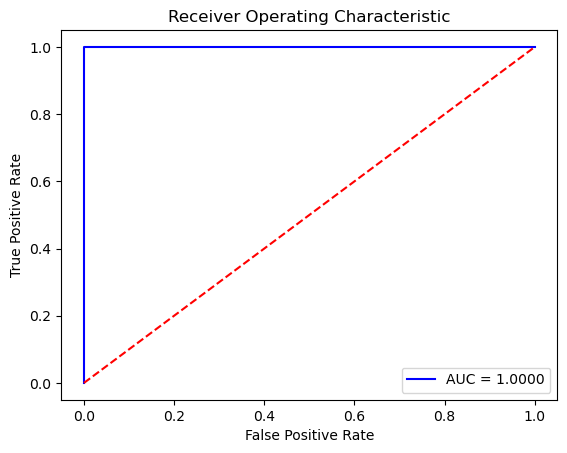

In [17]:
# Create relevant variables for ROC graph
fpr, tpr, threshold = metrics.roc_curve(test_y, y_hat)
roc_auc = metrics.auc(fpr, tpr)
sns.set_palette('pastel')

# Create plot
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)

# Create 50% accuracy line, for comparison 
plt.plot([0, 1], [0, 1],'r--')

# Create legend & labels
plt.legend(loc = 'lower right')
plt.title('Receiver Operating Characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()

THe AUC score for the XGB model is 1--literally perfect predictions.  This is not unexpected, but illustrates that the `is_tcp_syn` variable is following a non-stochastic process.  

Create a confusion matrix as well, for further illustration.

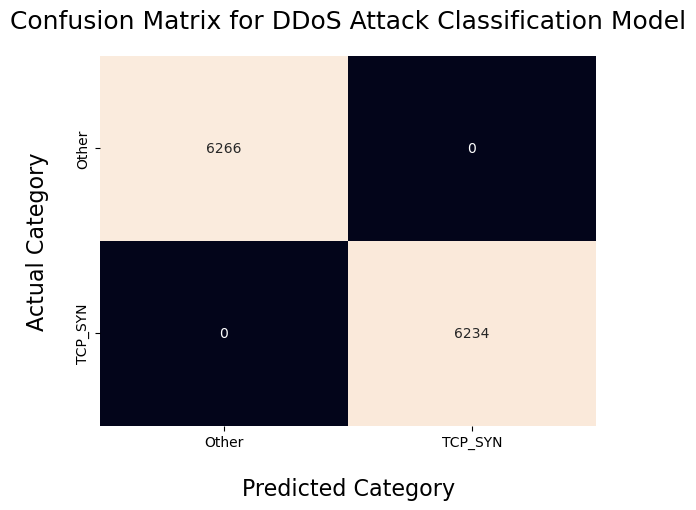

In [18]:
ax = sns.heatmap(confusion_matrix(test_y, y_hat), annot=True, fmt='d', cbar = False)

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Category", fontsize=16, labelpad=20)
ax.xaxis.set_ticklabels(['Other', 'TCP_SYN'])

# set y-axis label and ticks
ax.set_ylabel("Actual Category", fontsize=16, labelpad=20)
ax.yaxis.set_ticklabels(['Other', 'TCP_SYN'])

# set plot title
ax.set_title("Confusion Matrix for DDoS Attack Classification Model", fontsize=18, pad=20)

plt.show()

As the model is predicting perfectly, hyperparameter tuning is excluded from this analysis.  

### Feature Importance

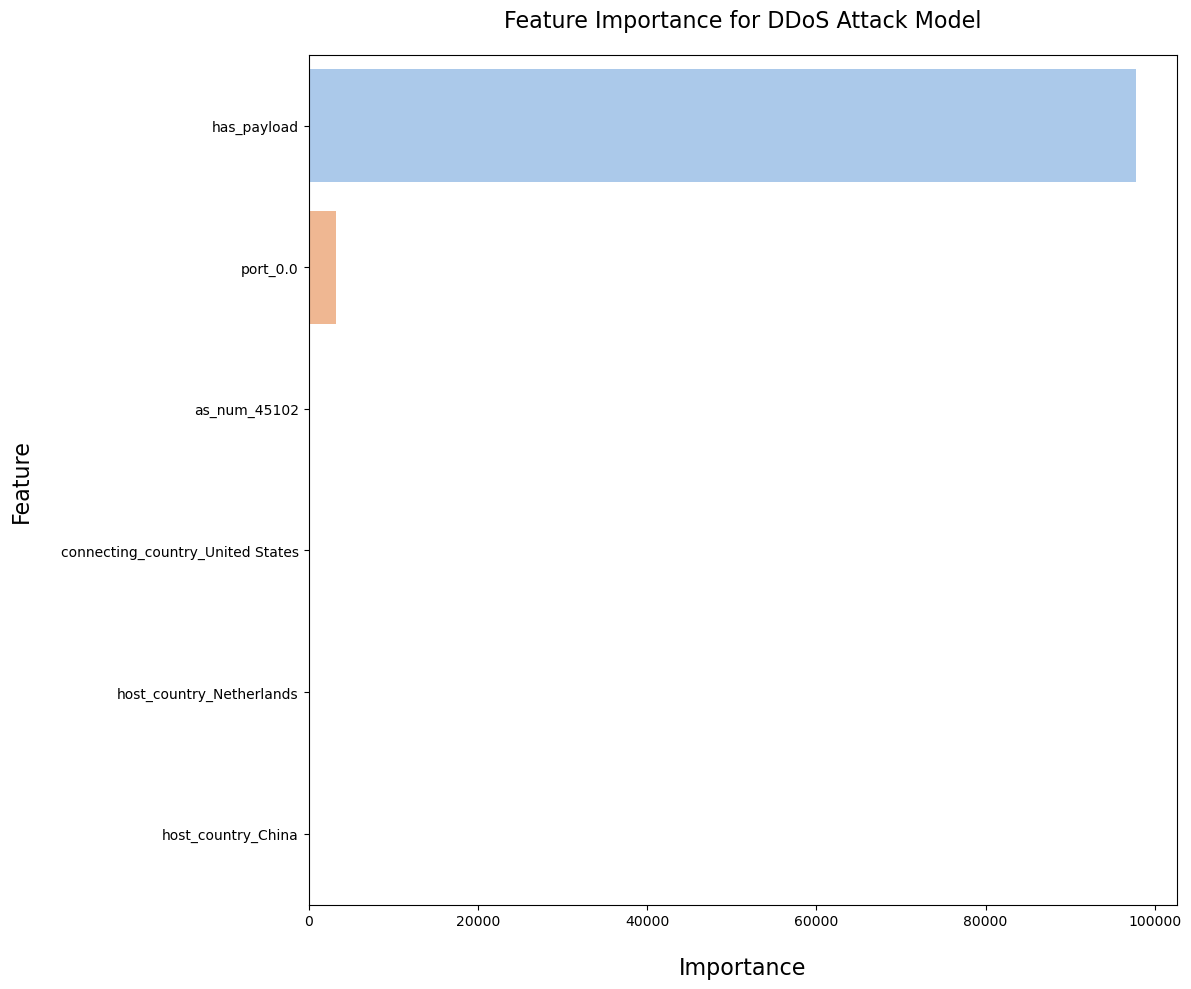

In [19]:
# Identify feature importance
xgb_features = pd.DataFrame(xgb_cl.get_booster().get_score(fmap='', importance_type='total_gain'), index = [0])
top_features = pd.melt(xgb_features).rename(columns = {'variable': 'Feature', 'value':'Importance'}).sort_values(by = 'Importance', ascending = False)[:10]

# Graph feature importance 
plt.figure(figsize=(12,10))
sns.barplot(x="Importance",
            y="Feature",
            data=top_features)
plt.title('Feature Importance for DDoS Attack Model', fontsize=16, pad=20)
plt.ylabel("Feature", fontsize=16, labelpad=20)
plt.xlabel("Importance", fontsize=16, labelpad=20)
plt.tight_layout()
plt.show()

As mentioned previously, the model is able to predict DDoS attacks perfectly, using primarily the `has_payload` feature.  

What if we dropped `has_payload`?  Are there any other features that are being crowded out?  

### Secondary XGB Model

In [20]:
# Initialize the XGB classifier
xgb_cl_2 = xgb.XGBClassifier()

# Fit the model based on the training data, excluding has_payload
xgb_cl_2.fit(train_x.drop('has_payload', axis = 1), train_y)

# Predict test values for is_tcp_syn (again, excluding has_payload)
y_hat_2 = xgb_cl_2.predict(test_x.drop('has_payload', axis = 1))

### Assess Secondary Model Performance

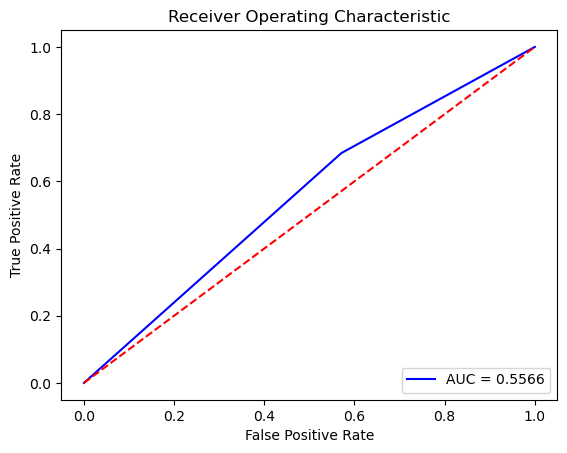

In [21]:
# Create relevant variables for second ROC graph
fpr, tpr, threshold = metrics.roc_curve(test_y, y_hat_2)
roc_auc = metrics.auc(fpr, tpr)

# Create plot
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)

# Create 50% accuracy line, for comparison 
plt.plot([0, 1], [0, 1],'r--')

# Create legend & labels
plt.legend(loc = 'lower right')
plt.title('Receiver Operating Characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()

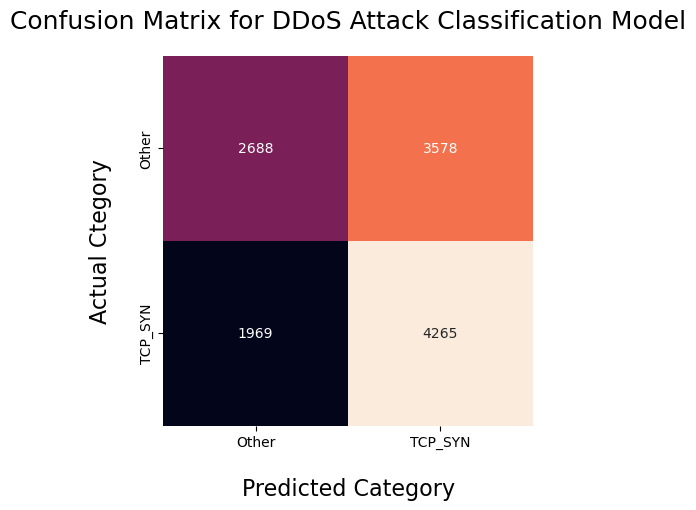

In [22]:
ax = sns.heatmap(confusion_matrix(test_y, y_hat_2), annot=True, fmt='d', cbar = False, square = True)

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Category", fontsize=16, labelpad=20)
ax.xaxis.set_ticklabels(['Other', 'TCP_SYN'])

# set y-axis label and ticks
ax.set_ylabel("Actual Ctegory", fontsize=16, labelpad=20)
ax.yaxis.set_ticklabels(['Other', 'TCP_SYN'])

# set plot title
ax.set_title("Confusion Matrix for DDoS Attack Classification Model", fontsize=18, pad=20)

plt.show()

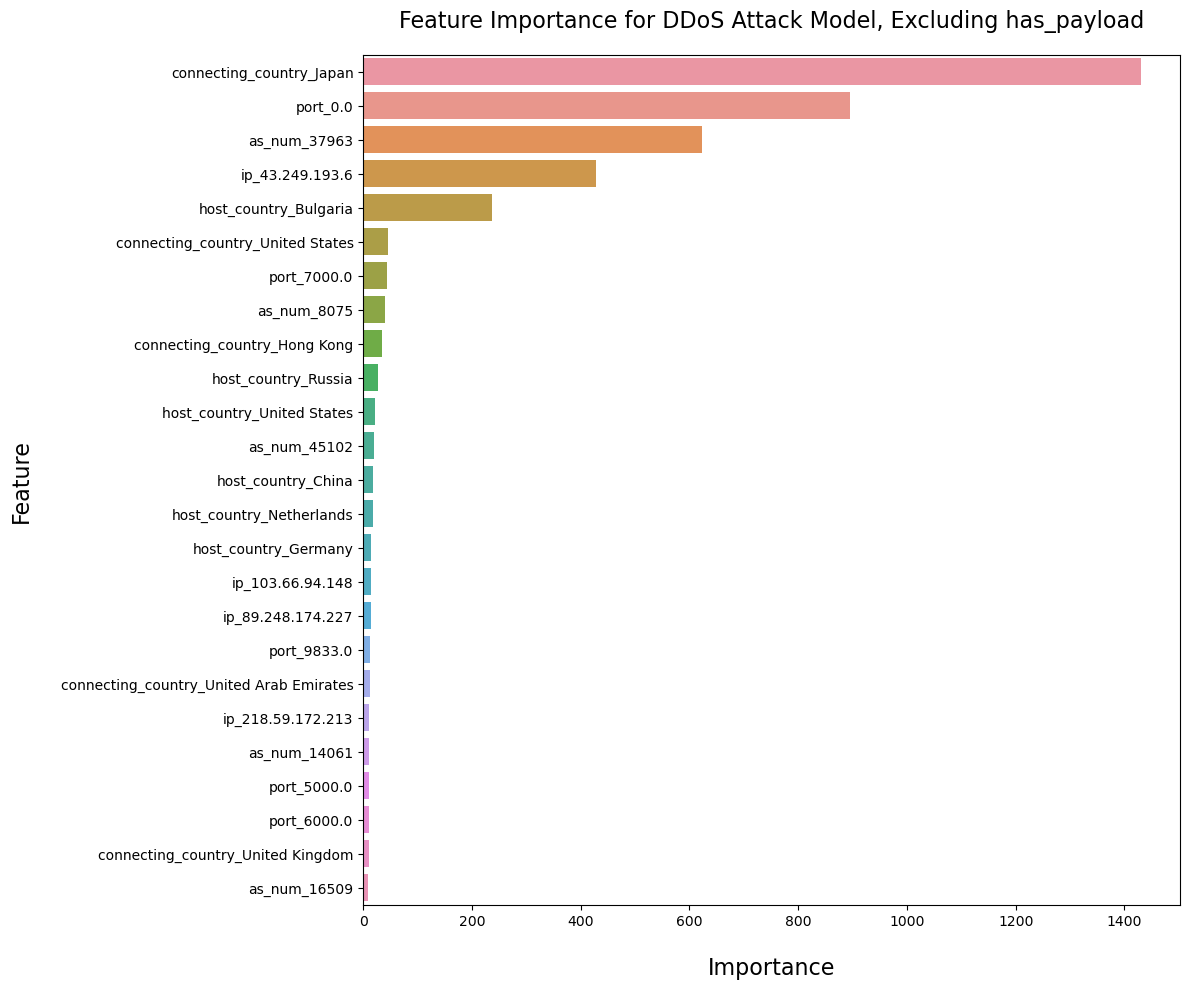

In [23]:
# Identify feature importance for booking, revenue models
xgb_features = pd.DataFrame(xgb_cl_2.get_booster().get_score(fmap='', importance_type='total_gain'), index = [0])
top_features = pd.melt(xgb_features).rename(columns = {'variable': 'Feature', 'value':'Importance'}).sort_values(by = 'Importance', ascending = False)[:25]

# Graph feature importance 
plt.figure(figsize=(12,10))
sns.barplot(x="Importance",
            y="Feature",
            data=top_features)
plt.title('Feature Importance for DDoS Attack Model, Excluding has_payload', fontsize=16, pad=20)
plt.ylabel("Feature", fontsize=16, labelpad=20)
plt.xlabel("Importance", fontsize=16, labelpad=20)
plt.tight_layout()
plt.show()

As anticipated, model performs <b><i> significantly </b></i> worse.  Still, gives very slight insight into what other features could be driving DDoS attacks, and may be worth continuing to investigate in the future.  